In [1]:
import time
import pickle
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from matplotlib import rcParams
rcParams['font.size'] = 14
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Definitions

In [2]:
# TSNE definitions
number_components = [x for x in range(1, 9)]

In [3]:
num_tests = 50 # number of tests to be performed and obtain average accuracy
samples_normal = 100
samples_abnormal = 15

In [4]:
# DBSCAN definitions
epsilon_configurations = [.1, .5, 1., 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20, 50, 80, 100]

In [5]:
# OC-SVM definitions
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0]
kernels = ['rbf', 'linear', 'sigmoid'] # , 'poly'
nus = [0.01, 0.1, .3, .5, .7, 1.]

In [6]:
folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc-demo'

### Importing dataset

In [7]:
with open(folder + '/compiled-dataset.h5', 'rb') as file:
    final_dataframe, scaled_dataframe, class_columns, class_names = pickle.load(file)
input_dim = final_dataframe.shape[1] - 3 # the last three columns are classes

### Helper functions

In [8]:
# sort the OCSVM results dictionary by the performance
def get_sorted_pairs_ocsvm(performance):
    values = sorted([[performance[kernel][nu][gamma]['false_positive_rate'], performance[kernel][nu][gamma]['false_negative_rate']] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x[0])
    return values

# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[layer][epsilon]['false_positive_rate'], performance[layer][epsilon]['false_negative_rate']] for layer in performance for epsilon in performance[layer]], key=lambda x: x[0])
    return values

# get best OCSVM f1 score
def get_best_ocsvm(performance):
    best_f1 = .0
    best = None
    for kernel in performance.keys():
        for nu in performance[kernel].keys():
            for gamma in performance[kernel][nu].keys():
                if performance[kernel][nu][gamma]['f1_score'] > best_f1:
                    best_f1 = performance[kernel][nu][gamma]['f1_score']
                    best = performance[kernel][nu][gamma]
    return best

# get best DBSCAN f1 score
def get_best_dbscan(performance):
    best_f1 = .0
    best = None
    for min_samples in performance.keys():
        for epsilon in performance[min_samples].keys():
            if performance[min_samples][epsilon]['f1_score'] > best_f1:
                best_f1 = performance[min_samples][epsilon]['f1_score']
                best = performance[min_samples][epsilon]
    return best

def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

### Running the algorithm with TSNE

In [9]:
tsne_dataframes = {}
for n_components in number_components:
    start_time = time.time()
    print('starting', n_components, '...')
    if n_components < 4:
        method = 'barnes_hut'
    else:
        method = 'exact'
    tsne = TSNE(n_components=n_components, verbose=1, n_iter=300, method=method)

    tsne_data = tsne.fit_transform(scaled_dataframe.drop(class_columns, axis=1))

    tsne_df = pd.DataFrame(data=tsne_data, columns=[f'tsne_{i}' for i in range(1, n_components+1)])

    class_df = pd.DataFrame(data=scaled_dataframe[class_columns], columns=class_columns)
    
    final_df = pd.concat([tsne_df, class_df], axis=1)
    tsne_dataframes[n_components] = final_df
    print('finished after {} seconds'.format(time.time() - start_time))

with open('./models/tsne_dataset.h5', 'wb') as file:
    pickle.dump({'tsne_dataframes': tsne_dataframes}, file)

starting 1 ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19882 samples in 0.072s...
[t-SNE] Computed neighbors for 19882 samples in 5.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19882
[t-SNE] Computed conditional probabilities for sample 2000 / 19882
[t-SNE] Computed conditional probabilities for sample 3000 / 19882
[t-SNE] Computed conditional probabilities for sample 4000 / 19882
[t-SNE] Computed conditional probabilities for sample 5000 / 19882
[t-SNE] Computed conditional probabilities for sample 6000 / 19882
[t-SNE] Computed conditional probabilities for sample 7000 / 19882
[t-SNE] Computed conditional probabilities for sample 8000 / 19882
[t-SNE] Computed conditional probabilities for sample 9000 / 19882
[t-SNE] Computed conditional probabilities for sample 10000 / 19882
[t-SNE] Computed conditional probabilities for sample 11000 / 19882
[t-SNE] Computed conditional probabilities for sample 12000 / 19882
[t-SNE] Computed conditional probab

In [10]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="attack",
    palette=sns.color_palette("hls", 7),
    data=tsne_dataframes[2],
    legend="full",
    alpha=0.3
)
plt.savefig('./figures/tsne_2dim.pdf')
plt.savefig('./figures/tsne_2dim.svg')
# plt.show()
plt.close()

### Running DBSCAN

In [11]:
performance_dbscan_tsne = {}
highest_f1 = 0.

for n_components in number_components:
    performance_dbscan_tsne[n_components] = {}
    for idm, min_samples in enumerate(min_samples_configurations):
        performance_dbscan_tsne[n_components][min_samples] = {}
        for ide, epsilon in enumerate(epsilon_configurations):
            performance_dbscan_tsne[n_components][min_samples][epsilon] = {}

print('npca\tMinPts\tepsilon\t\tfpr\tfnr\tf1')
for n_components in number_components:
    working_df = tsne_dataframes[n_components]
    for idm, min_samples in enumerate(min_samples_configurations):

        for ide, epsilon in enumerate(epsilon_configurations):

            clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')

            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []

            for test in range(num_tests):
                p1 = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                p2 = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

                # start copy
                for i in range(num_tests):
                    x_data_test = np.copy(x_data)
                    y_data_test = np.copy(y_data)
                    for clazz in range(1, len(class_names)):
                        x = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        x = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                        x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                        y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                    y_pred = clf.fit_predict(x_data_test)

                    tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                    fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                    tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                    fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                    if tpr == 0: # avoids division by zero
                        precision = 0.
                        recall = 0.
                        f1 = 0.
                    else:
                        precision = tpr / (tpr + fpr)
                        recall = tpr / (tpr + fnr)
                        f1 = 2 * precision * recall / (precision + recall)

                    true_positives.append(tpr)
                    false_negatives.append(fnr)
                    true_negatives.append(tnr)
                    false_positives.append(fpr)
                    precisions.append(precision)
                    recalls.append(recall)
                    f1_scores.append(f1)

            performance_dbscan_tsne[n_components][min_samples][epsilon]['n_components'] = n_components
            performance_dbscan_tsne[n_components][min_samples][epsilon]['min_samples'] = min_samples
            performance_dbscan_tsne[n_components][min_samples][epsilon]['epsilon'] = epsilon
            
            performance_dbscan_tsne[n_components][min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['precision'] = np.mean(precisions)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['recall'] = np.mean(recalls)
            performance_dbscan_tsne[n_components][min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
            msg = ''
            if performance_dbscan_tsne[n_components][min_samples][epsilon]['f1_score'] > highest_f1:
                msg = '\t * highest'
                highest_f1 = performance_dbscan_tsne[n_components][min_samples][epsilon]['f1_score']
            print(f'{n_components:>4}\t{min_samples:>6}\t', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_tsne[n_components][min_samples][epsilon]['false_positive_rate'],
                    performance_dbscan_tsne[n_components][min_samples][epsilon]['false_negative_rate'],
                    performance_dbscan_tsne[n_components][min_samples][epsilon]['f1_score']), msg)

print('done')

npca	MinPts	epsilon		fpr	fnr	f1
   1	     3	    0.1 	0.024	0.801	0.324	 	 * highest
   1	     3	    0.5 	0.000	0.985	0.030	 
   1	     3	    1.0 	0.000	0.994	0.012	 
   1	     3	    2.0 	0.000	1.000	0.000	 
   1	     3	    3.0 	0.000	1.000	0.000	 
   1	     3	    4.0 	0.000	1.000	0.000	 
   1	     3	    5.0 	0.000	1.000	0.000	 
   1	     3	   10.0 	0.000	1.000	0.000	 
   1	     5	    0.1 	0.071	0.558	0.583	 	 * highest
   1	     5	    0.5 	0.000	0.952	0.091	 
   1	     5	    1.0 	0.000	0.991	0.018	 
   1	     5	    2.0 	0.000	1.000	0.000	 
   1	     5	    3.0 	0.000	1.000	0.000	 
   1	     5	    4.0 	0.000	1.000	0.000	 
   1	     5	    5.0 	0.000	1.000	0.000	 
   1	     5	   10.0 	0.000	1.000	0.000	 
   1	     8	    0.1 	0.224	0.263	0.751	 	 * highest
   1	     8	    0.5 	0.010	0.833	0.281	 
   1	     8	    1.0 	0.000	0.983	0.033	 
   1	     8	    2.0 	0.000	1.000	0.000	 
   1	     8	    3.0 	0.000	1.000	0.000	 
   1	     8	    4.0 	0.000	1.000	0.000	 
   1	     8	    5.0 	0.000	1.000	

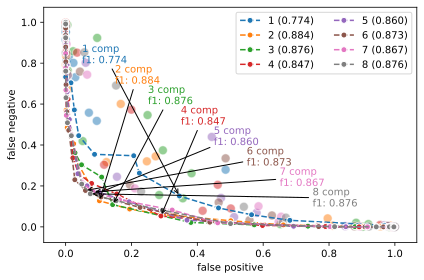

In [12]:
plt.figure()

for n_components in performance_dbscan_tsne.keys():
    
    sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_tsne[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)
    
    best_f1 = get_best_dbscan(performance_dbscan_tsne[n_components])
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker='o', s=80, alpha=0.5, edgecolors='white', zorder=1)
    
    plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=f"{n_components} ({best_f1['f1_score']:.3f})")
    
    plt.annotate(f"{n_components} comp\nf1: {best_f1['f1_score']:.3f}", 
                 xy=(best_f1['false_positive_rate'], best_f1['false_negative_rate']), xycoords='data', 
                 xytext=(-0.05+n_components*.1, 0.9-n_components*.1), textcoords='data',
                 color=ax.get_facecolors()[0],alpha=1.,
                 arrowprops=dict(arrowstyle='->'),
                 zorder=20)
    
plt.xlabel('false positive')
plt.ylabel('false negative')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/tsne_dbscan.pdf')
plt.savefig('./figures/tsne_dbscan.svg')
plt.show()

### Running OC-SVM

In [13]:
performance_ocsvm_tsne = {}
highest_f1 = .0

for n_components in number_components:
    performance_ocsvm_tsne[n_components] = {}
    for kernel in kernels:
        performance_ocsvm_tsne[n_components][kernel] = {}
        for nu in nus:
            performance_ocsvm_tsne[n_components][kernel][nu] = {}
            for gamma in gammas:
                performance_ocsvm_tsne[n_components][kernel][nu][gamma] = {}

print('npca\t    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for n_components in number_components:
    working_df = tsne_dataframes[n_components]
    for kernel in kernels:
        for nu in nus:
            for gamma in gammas:

                clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
                true_positives = []
                false_negatives = []
                true_negatives = []
                false_positives = []
                precisions = []
                recalls = []
                f1_scores = []
                for i in range(num_tests):
                    p1 = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                    p2 = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                    x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                    y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

                    clf.fit(x_data)

                    for test in range(num_tests):
                        x_data_test = np.copy(x_data)
                        y_data_test = np.copy(y_data)
                        for clazz in range(1, len(class_names)):
                            x = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                            x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                            y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                            x = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                            x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                            y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        y_pred = clf.predict(x_data_test)

                        tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                        fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                        tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                        fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                        if tpr == 0: # avoids division by zero
                            precision = 0.
                            recall = 0.
                            f1 = 0.
                        else:
                            precision = tpr / (tpr + fpr)
                            recall = tpr / (tpr + fnr)
                            f1 = 2 * precision * recall / (precision + recall)

                        true_positives.append(tpr)
                        false_negatives.append(fnr)
                        true_negatives.append(tnr)
                        false_positives.append(fpr)
                        precisions.append(precision)
                        recalls.append(recall)
                        f1_scores.append(f1)

                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['n_components'] = n_components
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['kernel'] = kernel
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['nu'] = nu
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['gamma'] = gamma
                
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['precision'] = np.mean(precisions)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['recall'] = np.mean(recalls)
                performance_ocsvm_tsne[n_components][kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
                msg = ''
                if performance_ocsvm_tsne[n_components][kernel][nu][gamma]['f1_score'] > highest_f1:
                    msg = '\t * highest'
                    highest_f1 = performance_ocsvm_tsne[n_components][kernel][nu][gamma]['f1_score']
                print(f'{n_components:>4}\t{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_tsne[n_components][kernel][nu][gamma]['false_positive_rate'],
                        performance_ocsvm_tsne[n_components][kernel][nu][gamma]['false_negative_rate'],
                        performance_ocsvm_tsne[n_components][kernel][nu][gamma]['f1_score']), msg)
print('done')

npca	    kernel	    nu	 gamma		fpr	fnr	f1
   1	       rbf	   0.01	  0.001 	0.013	0.555	0.610	 	 * highest
   1	       rbf	   0.01	    0.1 	0.074	0.299	0.789	 	 * highest
   1	       rbf	   0.01	    0.2 	0.069	0.320	0.778	 
   1	       rbf	   0.01	    0.5 	0.125	0.228	0.814	 	 * highest
   1	       rbf	   0.01	    0.7 	0.117	0.240	0.810	 
   1	       rbf	   0.01	    1.0 	0.146	0.256	0.787	 
   1	       rbf	    0.1	  0.001 	0.101	0.543	0.586	 
   1	       rbf	    0.1	    0.1 	0.105	0.262	0.800	 
   1	       rbf	    0.1	    0.2 	0.104	0.263	0.800	 
   1	       rbf	    0.1	    0.5 	0.142	0.190	0.830	 	 * highest
   1	       rbf	    0.1	    0.7 	0.118	0.200	0.833	 	 * highest
   1	       rbf	    0.1	    1.0 	0.141	0.227	0.808	 
   1	       rbf	    0.3	  0.001 	0.299	0.491	0.563	 
   1	       rbf	    0.3	    0.1 	0.302	0.202	0.760	 
   1	       rbf	    0.3	    0.2 	0.298	0.199	0.763	 
   1	       rbf	    0.3	    0.5 	0.313	0.141	0.791	 
   1	       rbf	    0.3	    0.7 	0.306	0.129	0.800	 
  

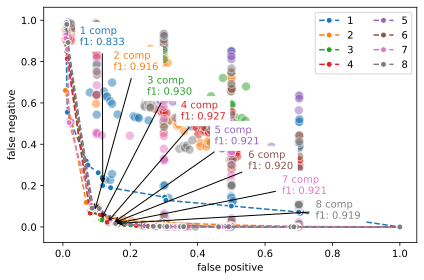

In [14]:
plt.figure()

for n_components in performance_dbscan_tsne.keys():
    
    sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_tsne[n_components])
    curve_fpr, curve_fnr = get_curve(sorted_pairs)
    
    ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                marker='o', s=80, alpha=0.5, edgecolors='white', zorder=1)
    
    plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=str(n_components))
    
    best_f1 = get_best_ocsvm(performance_ocsvm_tsne[n_components])
    plt.annotate(f"{n_components} comp\nf1: {best_f1['f1_score']:.3f}", 
                 xy=(best_f1['false_positive_rate'], best_f1['false_negative_rate']), xycoords='data', 
                 xytext=(-0.05+n_components*.1, 1.-n_components*.12), textcoords='data',
                 color=ax.get_facecolors()[0],alpha=1.,
                 backgroundcolor="w",
                 arrowprops=dict(arrowstyle='->'),
                 zorder=20)
    
plt.xlabel('false positive')
plt.ylabel('false negative')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/tsne_ocsvm.pdf')
plt.savefig('./figures/tsne_ocsvm.svg')
plt.show()

### Comparing DBSCAN and OCSVM

In [15]:
with open('./models/tsne_results.h5', 'wb') as file:
    pickle.dump({
        'performance_ocsvm_tsne': performance_ocsvm_tsne,
        'performance_dbscan_tsne': performance_dbscan_tsne
    }, file)

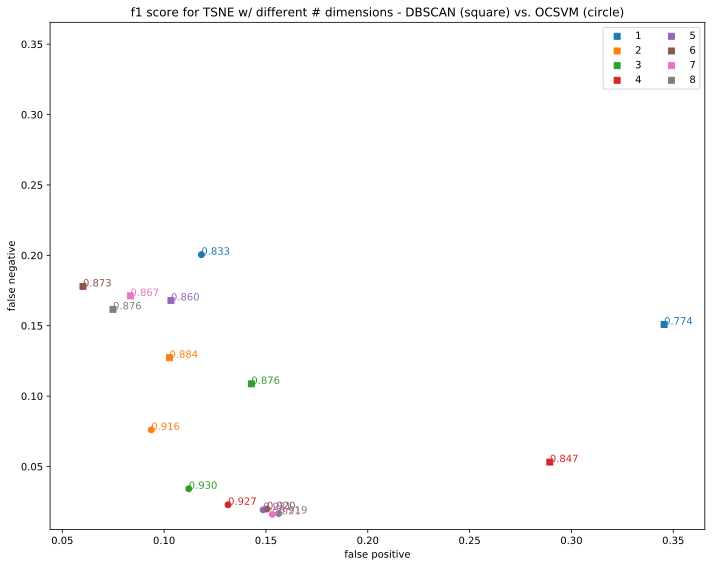

In [16]:
plt.figure(figsize=(10, 8))# 

for n_components in performance_dbscan_tsne.keys():
    
    best_f1_dbscan = get_best_dbscan(performance_dbscan_tsne[n_components])
    ax = plt.scatter(best_f1_dbscan['false_positive_rate'], best_f1_dbscan['false_negative_rate'], marker='s', label=f'{n_components}')
    plt.annotate(f"{best_f1_dbscan['f1_score']:.3f}", xy=(best_f1_dbscan['false_positive_rate'], best_f1_dbscan['false_negative_rate']), color=ax.get_facecolors()[0])
    
    best_f1_ocsvm = get_best_ocsvm(performance_ocsvm_tsne[n_components])
    plt.scatter(best_f1_ocsvm['false_positive_rate'], best_f1_ocsvm['false_negative_rate'], marker='o', color=ax.get_facecolors()[0])
    plt.annotate(f"{best_f1_ocsvm['f1_score']:.3f}", xy=(best_f1_ocsvm['false_positive_rate'], best_f1_ocsvm['false_negative_rate']), color=ax.get_facecolors()[0])
    
plt.title('f1 score for TSNE w/ different # dimensions - DBSCAN (square) vs. OCSVM (circle)')
plt.xlabel('false positive')
plt.ylabel('false negative')
x_lim = plt.xlim()
y_lim = plt.ylim()
plt.xlim(x_lim[0], max(x_lim[1], y_lim[1]))
plt.ylim(y_lim[0], max(x_lim[1], y_lim[1]))
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/tsne_summary.pdf')
plt.savefig('./figures/tsne_summary.svg')
plt.show()